### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [136]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [138]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [139]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [140]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [141]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [142]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [143]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [144]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

#   &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [145]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,   0.3565177828
i:  1,   0.7135147488
i:  2,   0.8535191218
i:  3,   0.5888727201
i:  4,   0.5479197486
---
i: 20,   0.1537631249
i: 21,   0.5800610462
i: 22,  -0.0494209449
i: 23,  -0.6566670209
i: 24,  -0.6023568558


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 1.0]<br>* 2nd set: [3.0, -2.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [146]:
# inputs
xs = [
  [2.0, 1.0],
  [3.0, -2.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [147]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate output, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [148]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  1.],
       [ 3., -2.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 1., -2.]])]


##### Common Activation Functions

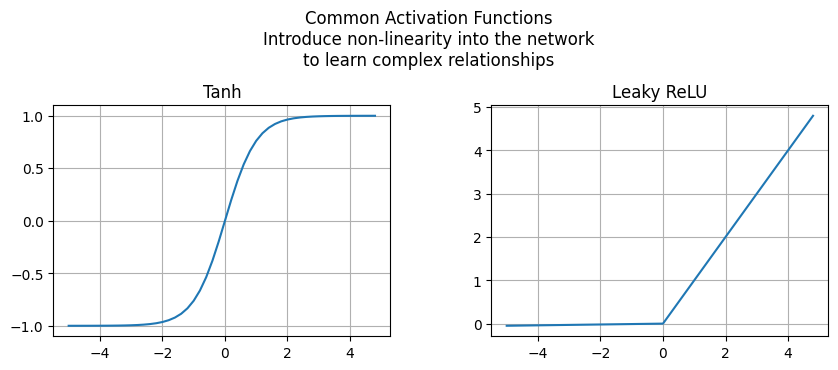

In [149]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [150]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[0.35651778 0.71351475]
 [0.58887272 0.54791975]
 [0.86687547 0.19364179]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 1.42655031 -0.35747615]
 [ 1.72566519  0.67077866]
 [ 1.92739272  2.21334281]]

bias (3, 1):
[[ 0.85351912]
 [-0.26836847]
 [ 0.06870406]]

weights_x_inputs_+_bias (3, 2):
[[2.28006944 0.49604297]
 [1.45729672 0.40241019]
 [1.99609678 2.28204687]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[0.97929537 0.45899948]
 [0.89712629 0.38200932]
 [0.96375077 0.97937625]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.76203158 -0.41699123 -0.9497839 ]
 [-0.67040051  0.11696899 -0.43933156]
 [ 0.91077408 -0.69268658 -0.72588313]]

input (3, 2):
[[0.97929537 0.45899948]
 [0.89712629 0.38200932]
 [0.96375077 0.97937625]]

weights_x_inputs (3, 2):
[[-2.03570275 -1.43926243]
 [-0.97499028 -0.69330

In [151]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err:            {err}')
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [-0.72693598 -0.61768176] <-- neural network output
desired output: [1.0, -1.0]
err:            [-1.72693598  0.38231824]
err_sq:         [2.98230788 0.14616724]
loss_mean:      1.5642375580845502
loss_sum:       3.1284751161691005 <-- sum(prediction_error)^2


##### Save original parameters

In [152]:
# save original parameters
param_org = [p.data for p in n.parameters()]

#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Example of calculating gradient for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [153]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum before increase Wo:  {loss_sum_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                    {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                     {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                       {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_sum before increase Wo:   3.1284751
W0_before:                     0.3565178
W0_after:                      0.3565278
W0_dif:                        0.0000100 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [154]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[0.35652778 0.71351475]
 [0.58887272 0.54791975]
 [0.86687547 0.19364179]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 1.42657031 -0.35744615]
 [ 1.72566519  0.67077866]
 [ 1.92739272  2.21334281]]

bias (3, 1):
[[ 0.85351912]
 [-0.26836847]
 [ 0.06870406]]

weights_x_inputs_+_bias (3, 2):
[[2.28008944 0.49607297]
 [1.45729672 0.40241019]
 [1.99609678 2.28204687]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[0.97929619 0.45902316]
 [0.89712629 0.38200932]
 [0.96375077 0.97937625]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.76203158 -0.41699123 -0.9497839 ]
 [-0.67040051  0.11696899 -0.43933156]
 [ 0.91077408 -0.69268658 -0.72588313]]

input (3, 2):
[[0.97929619 0.45902316]
 [0.89712629 0.38200932]
 [0.96375077 0.97937625]]

weights_x_inputs (3, 2):
[[-2.03570338 -1.43928047]
 [-0.97499083 -0.69331

##### Calculate gradient

In [155]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err:              {err}')
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- (changes in loss_sum) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:             [-0.72693622 -0.61769265]
desired output:   [1.0, -1.0]
err:              [-1.72693622  0.38230735]
err_sq:           [2.98230872 0.14615891]
loss_sum_before:  3.1284751161691005
loss_sum_after:   3.128467631515124

-- Calcuclate gradient --
loss_sum_dif:     -7.484653976597144e-06 <-- change in loss_sum
W0_dif:           1.0000000000010001e-05 <-- change in W0
W0_grad:          -0.7484653976589659 <-- (changes in loss_sum) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [156]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean}')
print(f'loss_sum:    {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc. {loss_sum_before}')


-- Calculate neural network Loss and gradient using Micrograd --
W0:          0.35651778283100954
ypred_data:  [-0.726935980082066, -0.6176817596986841]
ys:          [1.0, -1.0]
err_sq:      [2.9823078793020055, 0.14616723686709474]
loss_mean:   1.56423755808455
loss_sum:    3.1284751161691 <-- loss_sum, Micrograd calculation same as manual calc. 3.1284751161691005


##### Calculate gradients and adjust parameters using Micrograd

In [157]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --
  0      0.3565177828    -0.7484948257           0.05000         0.3939425241 <-- gradient same as manual calc. W0_grad -0.7484653977
  1      0.7135147488     0.5969944185           0.05000         0.6836650278
  2      0.8535191218    -0.2354985798           0.05000         0.8652940508
  3      0.5888727201     0.0591187949           0.05000         0.5859167803
  4      0.5479197486    -0.3051957450           0.05000         0.5631795358
  5     -0.2683684732    -0.0182627657           0.05000        -0.2674553349
  6      0.8668754661    -0.0711046360           0.05000         0.8704306979
  7      0.1936417921    -0.0420860299           0.05000         0.1957460936
  8      0.0687040603    -0.0364857054           0.05000         0.0705283455
  9     -0.7620315753    -0.1466047500           0.05000        -0.7547013378
 10     -0.4169912265    -0.1406552579           0.05000        -0.409958

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [158]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  # loss is mean-square-errors
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0  
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  # print('-------')

ypred: [Value(data = -0.616037214615437), Value(data = -0.5784298988153279)]
step: 0, loss: 1.3946488146174372
ypred: [Value(data = -0.5354373214959743), Value(data = -0.5373236118701258)]
step: 1, loss: 1.2858186041878188
ypred: [Value(data = -0.43983729163251867), Value(data = -0.4910798502394171)]
step: 2, loss: 1.1660655726040003
ypred: [Value(data = -0.3335751782439578), Value(data = -0.44886171326800817)]
step: 3, loss: 1.0410880835651395
ypred: [Value(data = -0.223916478252101), Value(data = -0.42453784369005004)]
step: 4, loss: 0.9145641195409615
ypred: [Value(data = -0.11718900300080641), Value(data = -0.4302514650648461)]
step: 5, loss: 0.786362330743345
ypred: [Value(data = -0.01519399499742435), Value(data = -0.4620877863211886)]
step: 6, loss: 0.6599841985518348
ypred: [Value(data = 0.08238045641882351), Value(data = -0.49891062846720946)]
step: 7, loss: 0.5465580925126268
ypred: [Value(data = 0.1726223474153493), Value(data = -0.5279747105353055)]
step: 8, loss: 0.4536808

##### Plot Loss

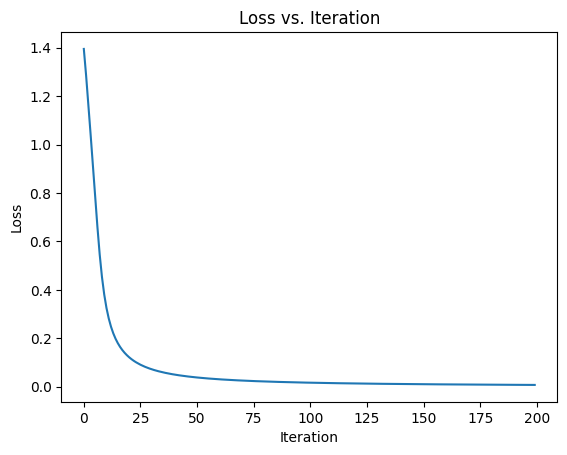

In [160]:
plot_losses(losses)

# TODO check loss_mean and loss_sum calc

##### Results at end of iteration

In [161]:
ypred = [n(x) for x in xs]
# loss is mean-square-errors
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n- Results at end of iteration -')
print(f'ypred_data: {ypred_data}')
print(f'loss: {loss.data}\n\n')

print(f'Optimized weight and bias matrices')
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)


- Results at end of iteration -
ypred_data: [0.9142707371022141, -0.9113645531809746]
loss: 0.015205748949805966


Optimized weight and bias matrices
--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[0.61455922 0.51520373]
 [0.28426796 1.07534448]
 [0.88051853 0.25494488]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 1.74432218  0.81327022]
 [ 1.64388041 -1.29788508]
 [ 2.01598193  2.13166582]]

bias (3, 1):
[[ 0.93577817]
 [-0.32356698]
 [ 0.08330867]]

weights_x_inputs_+_bias (3, 2):
[[ 2.68010034  1.74904839]
 [ 1.32031343 -1.62145206]
 [ 2.0992906   2.21497449]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.99064405  0.94126714]
 [ 0.86686185 -0.92483459]
 [ 0.9704106   0.9764504 ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.73994222 -0.33796418 -0.94415559]
 [-0.72670185 -0.08702235 -0.48339756]
 [ 0.73910879 -1.45726177 -0.83265653]]

in

##### Changes in parameters after optimization

In [162]:
# save parameters
param_optmz = [p.data for p in n.parameters()]
param_comp = zip(param_org, param_optmz)

# print(f'i        param_new      param_org      param_dif')
print(f'i   param_optimized      param_org      param_dif')
for i, param_org_new in enumerate(param_comp):
  p_org = param_org_new[0]
  p_new = param_org_new[1]  
  p_dif = p_new - p_org
  print(f'{i:<4} {p_new:>14.10f} {p_org:>14.10f} {p_dif:>14.10f}')  


i   param_optimized      param_org      param_dif
0      0.6145592250   0.3565177828   0.2580414421
1      0.5152037264   0.7135147488  -0.1983110223
2      0.9357781653   0.8535191218   0.0822590434
3      0.2842679621   0.5888727201  -0.3046047579
4      1.0753444847   0.5479197486   0.5274247361
5     -0.3235669786  -0.2683684732  -0.0551985054
6      0.8805185255   0.8668754661   0.0136430594
7      0.2549448778   0.1936417921   0.0613030857
8      0.0833086694   0.0687040603   0.0146046091
9     -0.7399422163  -0.7620315753   0.0220893590
10    -0.3379641782  -0.4169912265   0.0790270484
11    -0.9441555896  -0.9497838991   0.0056283095
12     0.7029037526   0.6960967839   0.0068069687
13    -0.7267018519  -0.6704005054  -0.0563013465
14    -0.0870223535   0.1169689945  -0.2039913480
15    -0.4833975608  -0.4393315612  -0.0440659997
16     0.7364720746   0.7831209272  -0.0466488526
17     0.7391087865   0.9107740782  -0.1716652917
18    -1.4572617745  -0.6926865812  -0.7645751933


#   &nbsp;
# - Build Same Model with PyTorch -

In [163]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)  
        return x

model = MLP_torch()

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5]
# ]

# # desired targets
# ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# # learning rate (i.e. step size)
# learning_rate = 0.05

losses = []
for epoch in range(200):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")

Epoch 0 loss: 1.048574686050415
Epoch 10 loss: 0.6601706743240356
Epoch 20 loss: 0.17169630527496338
Epoch 30 loss: 0.01911509409546852
Epoch 40 loss: 0.0015386388404294848
Epoch 50 loss: 0.00011294629075564444
Epoch 60 loss: 8.095167686406057e-06
Epoch 70 loss: 5.764158572674205e-07
Epoch 80 loss: 4.1034851960830565e-08
Epoch 90 loss: 2.9124525013912717e-09
Epoch 100 loss: 2.0834889369325538e-10
Epoch 110 loss: 1.496580637194711e-11
Epoch 120 loss: 1.0391687510491465e-12
Epoch 130 loss: 1.0835776720341528e-13
Epoch 140 loss: 1.0835776720341528e-13
Epoch 150 loss: 8.881784197001252e-14
Epoch 160 loss: 8.881784197001252e-14
Epoch 170 loss: 8.881784197001252e-14
Epoch 180 loss: 8.881784197001252e-14
Epoch 190 loss: 8.881784197001252e-14

Prediction:
tensor([[ 1.0000],
        [-1.0000]])
Loss: 8.881784197001252e-14


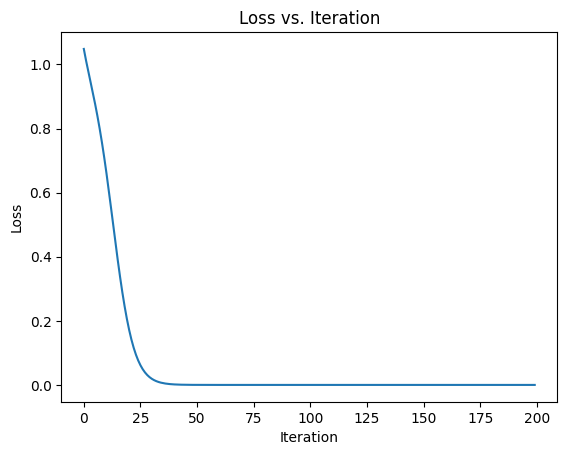

In [164]:
plot_losses(losses)

In [165]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')

# l_items is a list of [weight matrix, bias matrix, ..., weight matrix, bias matrix] 
l_items = list(model.parameters())
if len(l_items) % 2 == 0:  # True divisible by 2
  for i in range(0, len(l_items), 2):  # i: 0, 2, ..., len(l_items)-2
    if i == 0:  # use transposed t_xs as input only at the first time
      x0 = torch.clone(t_xs).detach()  # clone t_xs without autograd history
      input = torch.transpose(x0, 0, 1)  # columns of x0 becomes rows of input
    else:  # use previous output as input 
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 1.0], [3.0, -2.0]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([3, 2]):
tensor([[ 0.1923, -0.2733],
        [ 0.1574,  0.8995],
        [-0.2844,  0.3897]])

input,  torch.Size([2, 2]):
tensor([[ 2.,  3.],
        [ 1., -2.]])

w * input,  torch.Size([3, 2]):
tensor([[ 0.1113,  1.1234],
        [ 1.2143, -1.3269],
        [-0.1791, -1.6325]])

bT,  torch.Size([3, 1]):
tensor([[ 0.5049],
        [-0.1560],
        [ 0.4243]])

w * input + bT,  torch.Size([3, 2]):
tensor([[ 0.6162,  1.6283],
        [ 1.0584, -1.4829],
        [ 0.2453, -1.2082]])

output,  torch.Size([3, 2]):
tensor([[ 0.5485,  0.9258],
        [ 0.7850, -0.9020],
        [ 0.2405, -0.8361]])


layer: 1.0,  i: 2

w,  torch.Size([3, 3]):
tensor([[-0.3050, -0.8203, -0.7822],
        [ 0.0435,  0.7451, -0.2167],
        [ 0.3300,  0.5183, -0.3114]])

input,  torch.Size([3, 2]):
tensor([[ 0.5485,  0.9258],
        [ 0.7850, -0.9020],
        [ 0.2405, -0.8361]])

w * input,  torch.S

In [166]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [167]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(8.8818e-14)

In [168]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-2.9802e-07,  2.9802e-07]])
squared_difference: tensor([[8.8818e-14, 8.8818e-14]])


tensor(8.8818e-14)

In [169]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9999997019767761, -0.9999997019767761]

In [170]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

8.881784197001252e-14


In [171]:
len(squared_difference)


1

In [172]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(8.8818e-14)

In [173]:
torch.sum((output - torch.tensor(ys))**2)


tensor(1.7764e-13)

##### Check Output and Gradient Calculation with PyTorch

In [174]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [175]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [176]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.8374640094
i:  1,  -0.2517239751
i:  2,   0.7982961678
i:  3,   0.9830049654
i:  4,   0.4180145650
---
i: 36,   0.1962432686
i: 37,   0.7055955120
i: 38,  -0.4532096246
i: 39,   0.6194688802
i: 40,   0.9164409387


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [177]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [178]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.8374640,   w0.grad:  0.0000000
w1: -0.2517240,   w1.grad:  0.0000000
w2:  0.7982962,   w2.grad:  0.0000000
b:   0.9830050

layer: 0, neuron 1
w0:  0.4180146,   w0.grad:  0.0000000
w1: -0.7496982,   w1.grad:  0.0000000
w2:  0.9598244,   w2.grad:  0.0000000
b:  -0.1011164

layer: 0, neuron 2
w0:  0.1439901,   w0.grad:  0.0000000
w1: -0.7558343,   w1.grad:  0.0000000
w2: -0.0812240,   w2.grad:  0.0000000
b:   0.5015145

layer: 0, neuron 3
w0: -0.4851702,   w0.grad:  0.0000000
w1:  0.7925838,   w1.grad:  0.0000000
w2: -0.7132333,   w2.grad:  0.0000000
b:  -0.7956503

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0:  0.6522001,   w0.grad:  0.0000000
w1:  0.5939064,   w1.grad:  0.0000000
w2:  0.2541900,   w2.grad:  0.0000000
w3:  0.1603325,   w3.grad:  0.0000000
b:   0.2132496

layer: 1, neuron 1
w0:  0.4909089,   w0.grad:  0.0000000
w1: -0.2717197,   w1.grad:  0.0000000
w2:  0.5517704,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [179]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.83746401 -0.25172398  0.79829617]
 [ 0.41801457 -0.74969819  0.95982438]
 [ 0.1439901  -0.75583428 -0.081224  ]
 [-0.4851702   0.79258378 -0.71323333]]
b_mat(1, 4):
[[ 0.98300497 -0.1011164   0.50151451 -0.79565035]]

i: 1
w_mat(4, 4):
[[ 0.65220007  0.59390638  0.25418999  0.16033255]
 [ 0.49090888 -0.27171967  0.55177038 -0.64611904]
 [-0.68504422 -0.23087887  0.14634157  0.29994106]
 [ 0.78318305 -0.16053688 -0.51399724 -0.69861122]]
b_mat(1, 4):
[[ 0.2132496  -0.46441585  0.40289433  0.83389876]]

i: 2
w_mat(1, 4):
[[ 0.19624327  0.70559551 -0.45320962  0.61946888]]
b_mat(1, 1):
[[0.91644094]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [180]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.83746401 -0.25172398  0.79829617]
 [ 0.41801457 -0.74969819  0.95982438]
 [ 0.1439901  -0.75583428 -0.081224  ]
 [-0.4851702   0.79258378 -0.71323333]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 0.12145993  3.16326409]
 [-2.37288983  2.48365408]
 [-1.89829864  1.14719257]
 [ 2.12064426 -2.60471105]]

bias (4, 1):
[[ 0.98300497]
 [-0.1011164 ]
 [ 0.50151451]
 [-0.79565035]]

weights_x_inputs_plus_bias (4, 2):
[[ 1.10446489  4.14626905]
 [-2.47400624  2.38253768]
 [-1.39678413  1.64870708]
 [ 1.32499392 -3.4003614 ]]

output (4, 2):
[[ 0.80209709  0.99949937]
 [-0.98590504  0.98309954]
 [-0.88465455  0.92867999]
 [ 0.86802048 -0.99777653]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.65220007  0.59390638  0.25418999  0.16033255]
 [ 0.49090888 -0.27171967  0.55177038 -0.64611904]
 [-0.68504422 -0.23087887  0.14634157  0.29994106]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [181]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.717955261709497, 0.9851989728457752]
ys:                 [1.0, -1.0]
loss_data:          4.020564196185279


#### Micrograd backward pass and update parameters

In [182]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.8374640094    -0.1358571853           0.05000         0.8442568687
  1     -0.2517239751    -0.2040771859           0.05000        -0.2415201158
  2      0.7982961678     0.0680345592           0.05000         0.7948944399
  3      0.9830049654    -0.0679550843           0.05000         0.9864027196
  4      0.4180145650    -0.0016673308           0.05000         0.4180979316
  5     -0.7496981930    -0.0021707550           0.05000        -0.7495896553
  6      0.9598243844     0.0007135777           0.05000         0.9597887055
  7     -0.1011164036    -0.0008036435           0.05000        -0.1010762214
  8      0.1439900970    -0.0100008947           0.05000         0.1444901418
  9     -0.7558342779    -0.0246092690           0.05000        -0.7546038144
 10     -0.0812239998     0.0084942390           0.05000        -0.0816487118
 11      0.5015145114    -0.0058738953

### Improve Prediction with Parameter Iteration 

In [183]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.7464602492817992), Value(data = 0.9848329358067779)]
step: 0, loss: 4.0038441882576
-------
ypred: [Value(data = 0.7667873998819051), Value(data = 0.9843858922309235)]
step: 1, loss: 3.9921754861389607
-------
ypred: [Value(data = 0.782143408192375), Value(data = 0.9838627075145596)]
step: 2, loss: 3.9831727368610332
-------
ypred: [Value(data = 0.7941788494809094), Value(data = 0.9832628776264696)]
step: 3, loss: 3.9756939877722273
-------
ypred: [Value(data = 0.8038461954067889), Value(data = 0.982582279071846)]
step: 4, loss: 3.9691088083461064
-------
ypred: [Value(data = 0.8117387561765658), Value(data = 0.9818138060769083)]
step: 5, loss: 3.9630282578829874
-------
ypred: [Value(data = 0.8182464356824967), Value(data = 0.9809474608508147)]
step: 6, loss: 3.9571872007934075
-------
ypred: [Value(data = 0.8236351852546099), Value(data = 0.9799700949987418)]
step: 7, loss: 3.9513861249695026
-------
ypred: [Value(data = 0.8280907161504252), Value(data = 0.9788

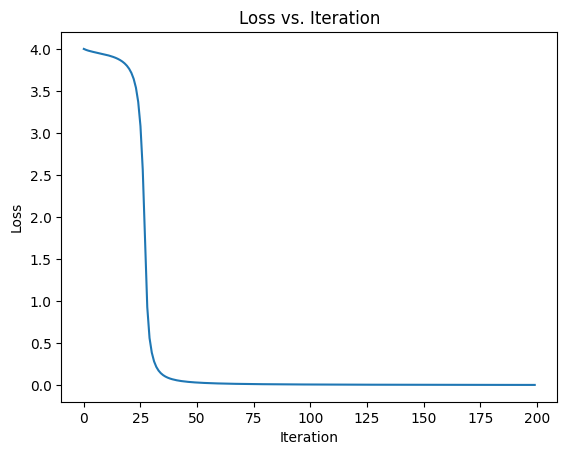

In [184]:
plot_losses(losses)

### Build same model with pyTorch 

In [185]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.4013739824295044
Epoch 10 loss: 0.11839723587036133
Epoch 20 loss: 0.0047308299690485
Epoch 30 loss: 0.00012652433360926807

Prediction:
tensor([[ 0.9988],
        [-0.9978]])
Loss: 4.5793508434144314e-06


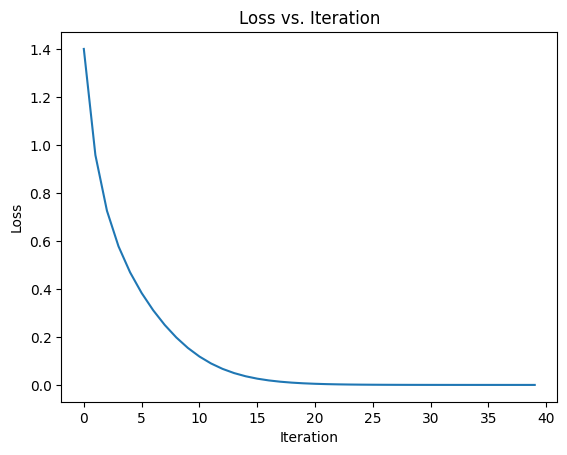

In [186]:
plot_losses(losses)

In [187]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.4994,  0.2530,  0.2884],
        [-0.0424, -0.1139, -0.1864],
        [ 0.3703, -0.6506,  0.4987],
        [-0.0892,  0.3270,  0.0184]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 1.4695,  1.3895],
        [-0.2403, -0.1065],
        [-1.7097,  2.0109],
        [ 0.7843, -0.5853]])

bT,  torch.Size([4, 1]):
tensor([[ 0.4482],
        [-0.4043],
        [ 0.1812],
        [-0.3465]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 1.9177,  1.8377],
        [-0.6446, -0.5108],
        [-1.5284,  2.1921],
        [ 0.4378, -0.9318]])

output,  torch.Size([4, 2]):
tensor([[ 0.9577,  0.9506],
        [-0.5680, -0.4706],
        [-0.9102,  0.9754],
        [ 0.4118, -0.7314]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.1588, -0.348

In [188]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [189]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9988, -0.9978]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(6.3285e-06)

In [190]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9988, -0.9978]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0012,  0.0022]])
squared_difference: tensor([[1.5160e-06, 4.8125e-06]])


tensor(3.1643e-06)

In [191]:
difference
len(squared_difference)

1

In [192]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(3.1643e-06)

In [193]:
torch.sum((output - torch.tensor(ys))**2)

tensor(6.3285e-06)